In [1]:
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import numpy as np
import pathlib
import os

MODEL = pathlib.Path('wall_recognizer.keras')
LABELLED = pathlib.Path('Dataset', 'Wall Recognizer', 'Labelled')

In [15]:
BUFFER = 128

file_paths = tf.data.Dataset.list_files(str(LABELLED/'*.png'), shuffle=False).shuffle(BUFFER, reshuffle_each_iteration=False)

In [16]:
def parse_images(file_path):
    # extract label
    label = tf.strings.split(file_path, os.path.sep)[-1]
    label = tf.strings.split(label, '_')[:-1]
    label = tf.strings.to_number(label, tf.int32)

    # load image
    image = tf.io.read_file(file_path)
    image = tf.io.decode_png(image, channels=1)
    image = tf.image.resize(image, [28, 28])
    image = tf.cast(image, tf.float32) / 255
    return image, label

dataset = file_paths.map(parse_images)

In [17]:
train_size = 800

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

In [18]:
image = iter(train_dataset).__next__()
print(image[0].shape)

(28, 28, 1)


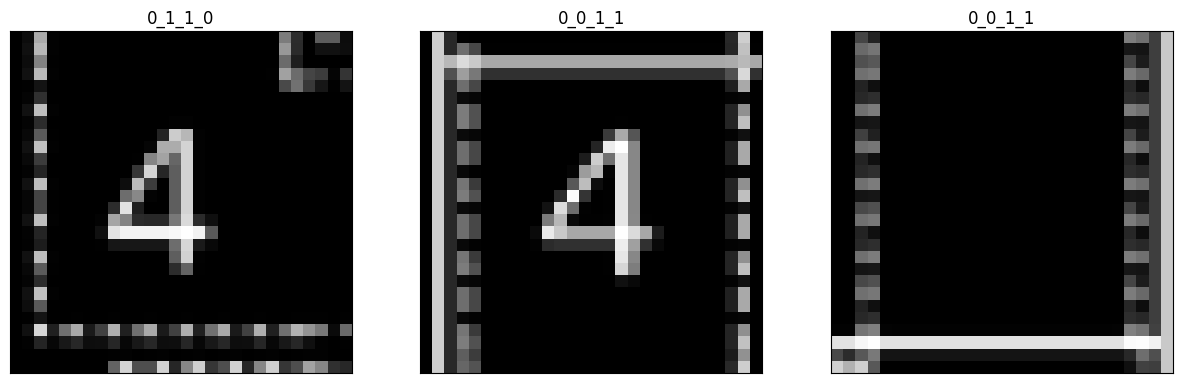

In [19]:
plt.figure(figsize=(15, 5))
for i, (image, label) in zip(range(3), iter(train_dataset)):
    label = label.numpy().astype(np.uint8).tolist()

    plt.subplot(1, 3, i + 1)
    plt.imshow(image, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('_'.join([str(x) for x in label]))
plt.show()

In [20]:
train_dataset = train_dataset.batch(1)
test_dataset = test_dataset.batch(1)

In [21]:
def get_model():
    model = keras.Sequential()

    # input layer
    model.add(keras.layers.InputLayer(input_shape=(28, 28, 1)))

    # first convolution layer
    model.add(keras.layers.Conv2D(32, (5, 5), padding='same', kernel_initializer='he_uniform'))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # second convolution layer
    model.add(keras.layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform'))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # transition to fully connected layers
    model.add(keras.layers.Flatten())

    # first dense layer
    model.add(keras.layers.Dense(64, kernel_initializer='he_uniform'))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dropout(0.5))

    # second dense layer
    model.add(keras.layers.Dense(64, kernel_initializer='he_uniform'))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dropout(0.5))

    # output layer
    model.add(keras.layers.Dense(4, kernel_initializer='he_uniform', activation='sigmoid'))
    return model

In [22]:
# create a model
model = get_model()
print(model.summary())
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics='accuracy'
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 re_lu_4 (ReLU)              (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 re_lu_5 (ReLU)              (None, 14, 14, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                 

In [23]:
for file in os.listdir('Checkpoints'):
    os.remove(f'Checkpoints/{file}')

In [24]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='Checkpoints/{epoch:02d}-{val_loss:.2f}.hdf5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [25]:
history = model.fit(train_dataset, epochs=100, validation_data=test_dataset, callbacks=[model_checkpoint_callback])

Epoch 1/100
800/800 [==============================] - 5s 4ms/step - loss: 0.5334 - accuracy: 0.3438 - val_loss: 0.4064 - val_accuracy: 0.9843
Epoch 2/100
800/800 [==============================] - 3s 4ms/step - loss: 0.3882 - accuracy: 0.3762 - val_loss: 0.2516 - val_accuracy: 0.7677
Epoch 3/100
800/800 [==============================] - 3s 4ms/step - loss: 0.2853 - accuracy: 0.3913 - val_loss: 0.2244 - val_accuracy: 0.5669
Epoch 4/100
800/800 [==============================] - 3s 4ms/step - loss: 0.2545 - accuracy: 0.4238 - val_loss: 0.1696 - val_accuracy: 0.5394
Epoch 5/100
800/800 [==============================] - 3s 4ms/step - loss: 0.2256 - accuracy: 0.3875 - val_loss: 0.1672 - val_accuracy: 0.3465
Epoch 6/100
800/800 [==============================] - 3s 4ms/step - loss: 0.1911 - accuracy: 0.3825 - val_loss: 0.1368 - val_accuracy: 0.4449
Epoch 7/100
800/800 [==============================] - 3s 4ms/step - loss: 0.1628 - accuracy: 0.4125 - val_loss: 0.0842 - val_accuracy: 0.4724

In [26]:
model.evaluate(test_dataset)

254/254 [==============================] - 1s 2ms/step - loss: 0.0260 - accuracy: 0.0000e+00


[0.026007825508713722, 0.0]

In [30]:
predictions = (model.predict(test_dataset) < 0.5)[0]
tuple(predictions)

254/254 [==============================] - 1s 2ms/step


(False, False, True, False)